# Klassificering i kod (Breast Cancer)
I den här notebooken bygger vi en **binär klassificerare** steg-för-steg:

1. Installera och importera det vi behöver  
2. Ladda dataset och förstå datan (EDA + visualiseringar)  
3. Dela upp i Train/Validation/Test  
4. Bygga baselines  
5. Träna 3 modeller (LogReg, Decision Tree, Random Forest)  
6. Utvärdera på validation (confusion matrix, precision/recall/F1 + ROC/AUC)  
7. Välja kandidatmodell  
8. Förbättra med GridSearchCV (Hyperparameter tuning)  
9. Träna om på train+val och göra sluttest på test

1. Installera och importera det vi behöver 
2. Ladda dataset
3. Train/Validation/Test split
4. EDA
5. Bygga baselines 
6. Träna 3 modeller (LogReg, Decision Tree, Random Forest) 
7. Utvärdera på validation (confusion matrix, precision/recall/F1) 
8. ROC/AUC
9. Förbättra med GridSearchCV (Hyperparameter tuning)
10. Refit på train+val och sluttest på test

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score
)

sns.set_context("notebook")

## Ladda Data

In [4]:
breast_cancer = load_breast_cancer()

# print(breast_cancer.DESCR)

In [5]:
X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
y = pd.Series(breast_cancer.target, name="target")

target_names = breast_cancer.target_names

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Mappning 0/1 -> klassnamn:", dict(enumerate(target_names)))

print("\nKlassfördelning (hela datasetet):")
print(y.value_counts())

print("\nKlassfördelning i procent:")
print(y.value_counts(normalize=True))

X shape: (569, 30)
y shape: (569,)
Mappning 0/1 -> klassnamn: {0: np.str_('malignant'), 1: np.str_('benign')}

Klassfördelning (hela datasetet):
target
1    357
0    212
Name: count, dtype: int64

Klassfördelning i procent:
target
1    0.627417
0    0.372583
Name: proportion, dtype: float64


## Train / Validation / Test split

- **Train**: modellen lär sig här
- **Validation**: vi jämför modeller och väljer inställningar här
- **Test**: används EN gång i slutet som ett "ärligt prov"

Vi använder `stratify` så klassfördelningen blir liknande i alla delar

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.40,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)


print("\nKlassfördelning train:")
print(y_train.value_counts(normalize=True))
print("\nKlassfördelning val:")
print(y_val.value_counts(normalize=True))
print("\nKlassfördelning test:")
print(y_test.value_counts(normalize=True))

Train: (341, 30) (341,)
Val  : (114, 30) (114,)
Test : (114, 30) (114,)

Klassfördelning train:
target
1    0.627566
0    0.372434
Name: proportion, dtype: float64

Klassfördelning val:
target
1    0.631579
0    0.368421
Name: proportion, dtype: float64

Klassfördelning test:
target
1    0.622807
0    0.377193
Name: proportion, dtype: float64


## EDA

In [9]:
display(X_train.head())

print("\nSaknade värden (train)")
print(X_train.isna().sum().sort_values(ascending=False).head(10))

print("\nSammanfattning (train)")
display(X_train.describe().T.head(10))

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
525,8.571,13.10,54.53,221.3,0.1036,0.07632,0.025650,0.015100,0.1678,0.07126,...,9.473,18.45,63.30,275.6,0.1641,0.22350,0.175400,0.08512,0.2983,0.10490
39,13.480,20.82,88.40,559.2,0.1016,0.12550,0.106300,0.054390,0.1720,0.06419,...,15.530,26.02,107.30,740.4,0.1610,0.42250,0.503000,0.22580,0.2807,0.10710
58,13.050,19.31,82.61,527.2,0.0806,0.03789,0.000692,0.004167,0.1819,0.05501,...,14.230,22.25,90.24,624.1,0.1021,0.06191,0.001845,0.01111,0.2439,0.06289
342,11.060,14.96,71.49,373.9,0.1033,0.09097,0.053970,0.033410,0.1776,0.06907,...,11.920,19.90,79.76,440.0,0.1418,0.22100,0.229900,0.10750,0.3301,0.09080
229,12.830,22.33,85.26,503.2,0.1088,0.17990,0.169500,0.068610,0.2123,0.07254,...,15.200,30.15,105.30,706.0,0.1777,0.53430,0.628200,0.19770,0.3407,0.12430



Saknade värden (train)
mean radius               0
mean texture              0
mean perimeter            0
mean area                 0
mean smoothness           0
mean compactness          0
mean concavity            0
mean concave points       0
mean symmetry             0
mean fractal dimension    0
dtype: int64

Sammanfattning (train)


,count,mean,std,min,25%,50%,75%,max
mean radius,341.0,14.066660,3.462553,6.98100,11.67000,13.27000,15.78000,25.22000
mean texture,341.0,19.301906,4.564336,9.71000,15.82000,18.83000,21.98000,39.28000
mean perimeter,341.0,91.511114,23.860522,43.79000,74.72000,85.89000,105.70000,171.50000
mean area,341.0,647.823754,333.929733,143.50000,419.80000,542.90000,782.60000,1878.00000
mean smoothness,341.0,0.095785,0.013229,0.06251,0.08597,0.09463,0.10460,0.13980
mean compactness,341.0,0.102525,0.053285,0.01938,0.06159,0.08751,0.12960,0.34540
mean concavity,341.0,0.088216,0.081405,0.00000,0.02688,0.05892,0.13240,0.42640
mean concave points,341.0,0.047773,0.038037,0.00000,0.01967,0.03263,0.07415,0.18450
mean symmetry,341.0,0.180738,0.028631,0.11670,0.16090,0.17820,0.19590,0.30400
mean fractal dimension,341.0,0.062732,0.007238,0.04996,0.05746,0.06129,0.06650,0.09575


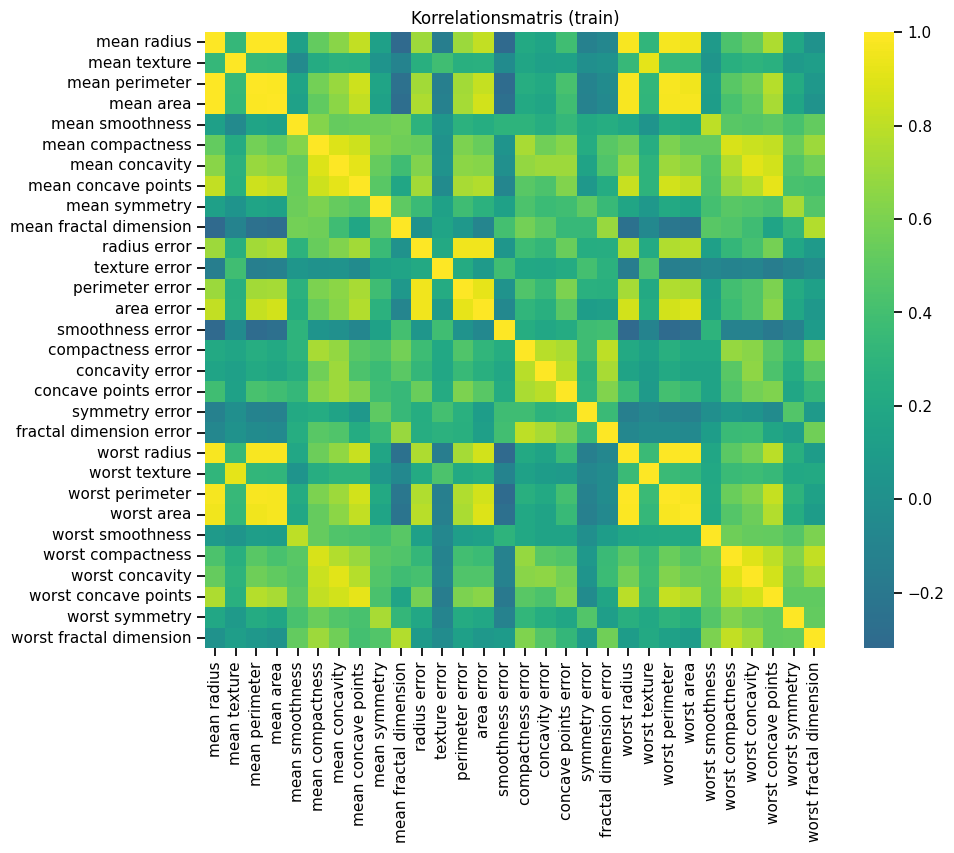

In [10]:
corr_matrix = X_train.corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap="viridis", center=0)
plt.title("Korrelationsmatris (train)")
plt.show()

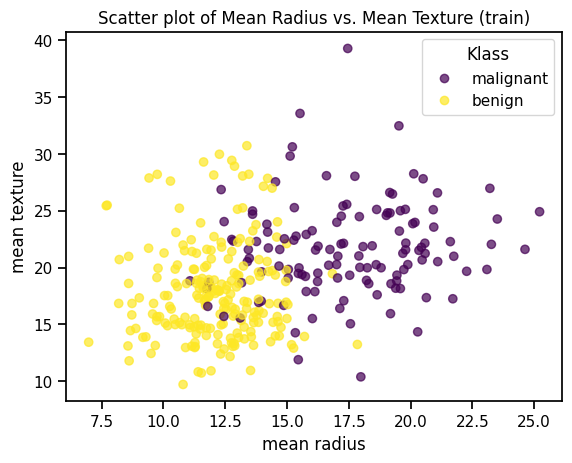

In [11]:
plt.figure()
scatter = plt.scatter(
    X_train["mean radius"],
    X_train["mean texture"],
    c=y_train,
    cmap=plt.get_cmap("viridis"),
    alpha=0.7
)

plt.xlabel("mean radius")
plt.ylabel("mean texture")
plt.title("Scatter plot of Mean Radius vs. Mean Texture (train)")
plt.legend(handles=scatter.legend_elements()[0], labels=list(target_names), title="Klass")
plt.show()

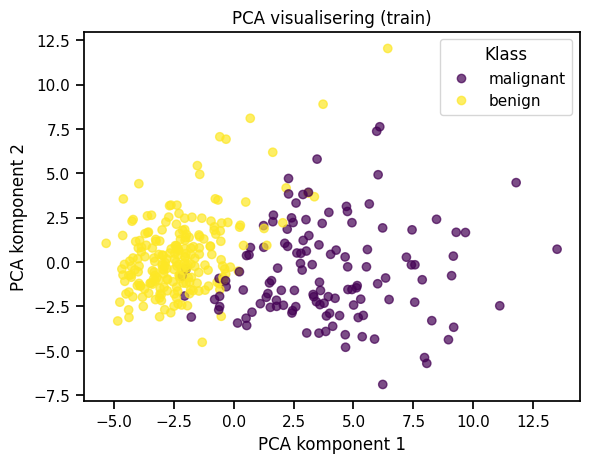

In [12]:
pca_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2, random_state=42))
])

X_train_pca = pca_pipeline.fit_transform(X_train)
X_val_pca = pca_pipeline.transform(X_val)
X_test_pca = pca_pipeline.transform(X_test)

plt.figure()
scatter = plt.scatter(
    X_train_pca[:, 0],
    X_train_pca[:, 1],
    c=y_train,
    cmap=plt.get_cmap("viridis"),
    alpha=0.7
)

plt.xlabel("PCA komponent 1")
plt.ylabel("PCA komponent 2")
plt.title("PCA visualisering (train)")
plt.legend(handles=scatter.legend_elements()[0], labels=list(target_names), title="Klass")
plt.show()

## Baselines

In [14]:
majority_class = y_train.value_counts().idxmax()
y_val_pred_baseline = np.full(shape=len(y_val), fill_value=majority_class)

print("Egen baseline (VAL)")
print("Majority class i train:", majority_class, "-", target_names[majority_class])

print("Accuracy :", accuracy_score(y_val, y_val_pred_baseline))
print("Precision:", precision_score(y_val, y_val_pred_baseline, zero_division=0))
print("Recall   :", recall_score(y_val, y_val_pred_baseline, zero_division=0))
print("F1       :", f1_score(y_val, y_val_pred_baseline, zero_division=0))

Egen baseline (VAL)
Majority class i train: 1 - benign
Accuracy : 0.631578947368421
Precision: 0.631578947368421
Recall   : 1.0
F1       : 0.7741935483870968


In [15]:
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)
y_val_pred_dummy = dummy.predict(X_val)

print("DummyClassifier baseline (VAL)")
print("Accuracy :", accuracy_score(y_val, y_val_pred_dummy))
print("Precision:", precision_score(y_val, y_val_pred_dummy, zero_division=0))
print("Recall   :", recall_score(y_val, y_val_pred_dummy, zero_division=0))
print("F1       :", f1_score(y_val, y_val_pred_dummy, zero_division=0))

DummyClassifier baseline (VAL)
Accuracy : 0.631578947368421
Precision: 0.631578947368421
Recall   : 1.0
F1       : 0.7741935483870968


## Träna modeller

### Logistic Regression
En linjär modell som försöker hitta en linje/ett plan (hyperplan) som skiljer klasserna åt.
Ger ofta sannolikheter och är en stark, tolkbar baseline.

### Decision Tree
Bygger regler genom att dela upp datan i steg:
"om feature <= värde, gå vänster, annars höger".
Kan fånga icke-linjära mönster men kan överanpassa.

### Random Forest
Många beslutsträd som tränas på slumpmässiga variationer av datan och features.
De röstar.
ofta stabilt och bra prestanda utan mycket tuning.

In [25]:
logreg = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=5000,
        random_state=42
    ))
])

tree = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", DecisionTreeClassifier(
        random_state=42
    ))
])

rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])


models = {
    "LogisticRegression": logreg,
    "DecisionTree": tree,
    "RandomForest": rf
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print("Tränade:", name)

Tränade: LogisticRegression
Tränade: DecisionTree
Tränade: RandomForest


## Utvärdering

In [19]:
def evaluate_on_validation(model, model_name, X_val, y_val, target_names):
    """
    Utvärderar modell på validation-data.
    """

    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)


    print(f"\n=========================================")
    print(f"{model_name} - VALIDATION")
    print(f"\n=========================================")
    print(f"Accuracy  : {acc:.3f}")
    print(f"Precicion : {prec:.3f}")
    print(f"Recall    : {rec:.3f}")
    print(f"F1        : {f1:.3f}")


    cm = confusion_matrix(y_val, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot()
    plt.title(f"Confusion matrix - {model_name} (VAL)")
    plt.show()

    print("\nDetaljer per klass (classification_report)")
    print(classification_report(y_val, y_pred, target_names=target_names, zero_division=0))

    tn, fp, fn, tp = cm.ravel()
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    print("Tolkning")
    print("- FP: vi flaggade positivt med det var negativt")
    print("- FN: vi missade positivt (ofta allvarligt i medicinska exempel)")

    return { "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "cm": cm }


LogisticRegression - VALIDATION

Accuracy  : 0.991
Precicion : 1.000
Recall    : 0.986
F1        : 0.993


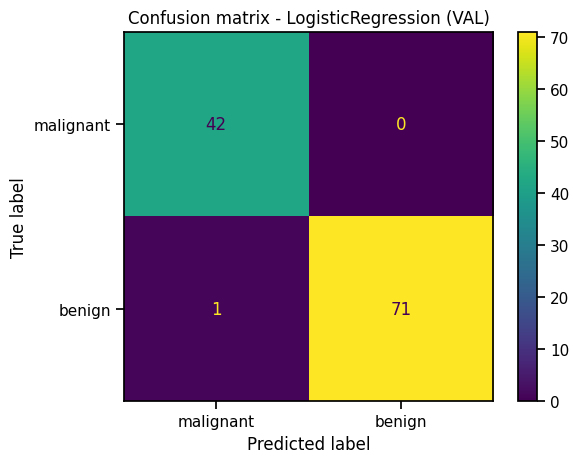


Detaljer per klass (classification_report)
              precision    recall  f1-score   support

   malignant       0.98      1.00      0.99        42
      benign       1.00      0.99      0.99        72

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114

TN=42, FP=0, FN=1, TP=71
Tolkning
- FP: vi flaggade positivt med det var negativt
- FN: vi missade positivt (ofta allvarligt i medicinska exempel)

DecisionTree - VALIDATION

Accuracy  : 0.965
Precicion : 0.972
Recall    : 0.972
F1        : 0.972


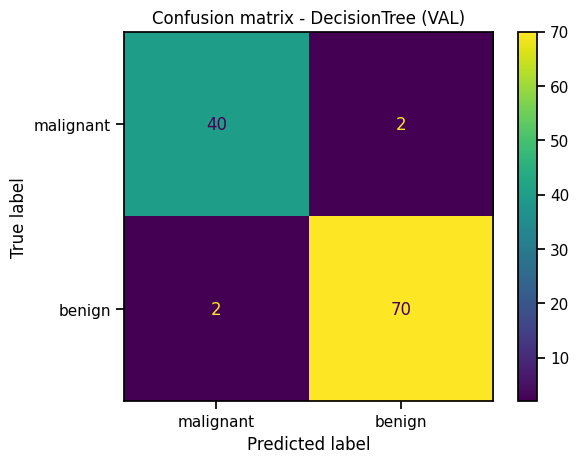


Detaljer per klass (classification_report)
              precision    recall  f1-score   support

   malignant       0.95      0.95      0.95        42
      benign       0.97      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114

TN=40, FP=2, FN=2, TP=70
Tolkning
- FP: vi flaggade positivt med det var negativt
- FN: vi missade positivt (ofta allvarligt i medicinska exempel)

RandomForest - VALIDATION

Accuracy  : 0.965
Precicion : 0.959
Recall    : 0.986
F1        : 0.973


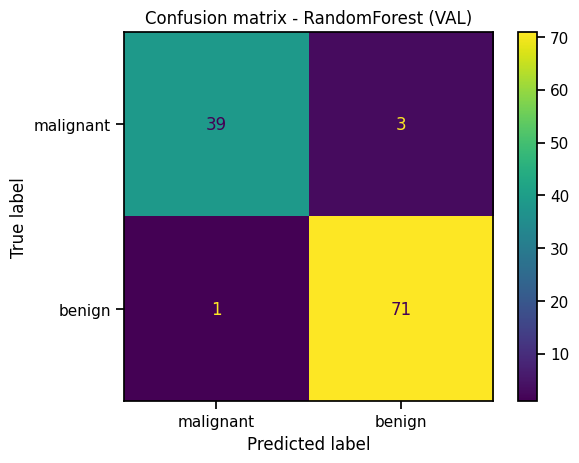


Detaljer per klass (classification_report)
              precision    recall  f1-score   support

   malignant       0.97      0.93      0.95        42
      benign       0.96      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

TN=39, FP=3, FN=1, TP=71
Tolkning
- FP: vi flaggade positivt med det var negativt
- FN: vi missade positivt (ofta allvarligt i medicinska exempel)


,accuracy,precision,recall,f1
LogisticRegression,0.991228,1.000000,0.986111,0.993007
RandomForest,0.964912,0.959459,0.986111,0.972603
DecisionTree,0.964912,0.972222,0.972222,0.972222


In [21]:
val_resluts = {}

for name, model in models.items():
    val_resluts[name] = evaluate_on_validation(model, name, X_val, y_val, target_names)

summary_table = pd.DataFrame({
    name: {
        "accuracy": res["accuracy"],
        "precision": res["precision"],
        "recall": res["recall"],
        "f1": res["f1"]
    }
    for name, res in val_resluts.items()
}).T


display(summary_table.sort_values(by="f1", ascending=False))

## ROC/AUC

In [22]:
def plot_roc_curve(model, model_name, X_val, y_val):
    if not hasattr(model, "predict_proba"):
        print(f"{model_name} har inte predict_proba - hoppar ROC")
        return None
    
    y_proba_class1 = model.predict_proba(X_val)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_val, y_proba_class1)
    auc = roc_auc_score(y_val, y_proba_class1)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(f"ROC - {model_name} (AUC = {auc:.3f})")
    plt.show()

    return auc

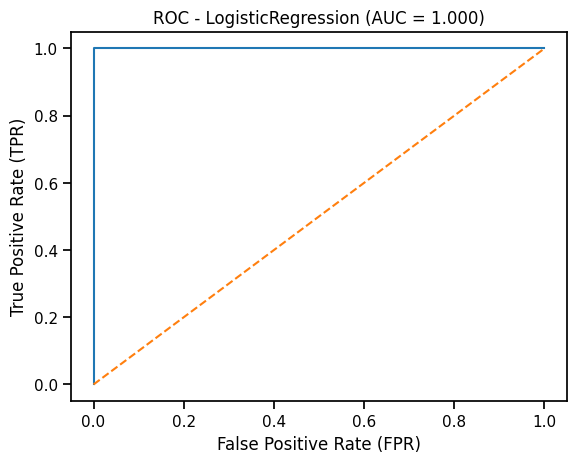

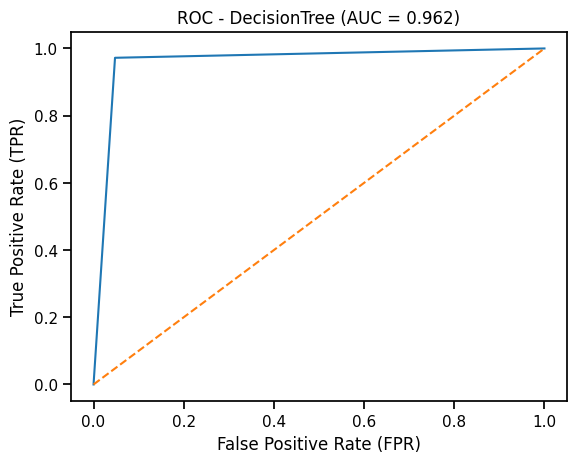

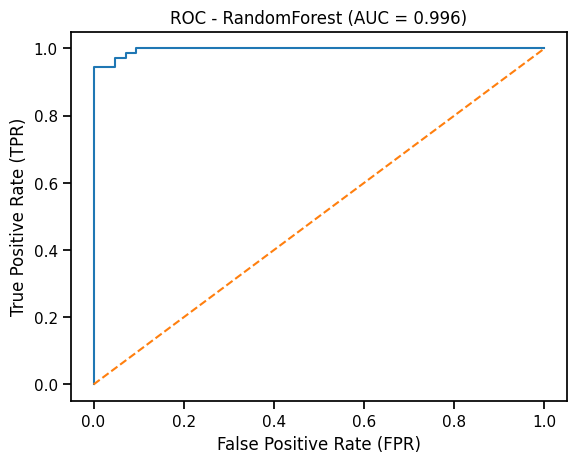

{'LogisticRegression': 1.0,
 'DecisionTree': 0.9623015873015873,
 'RandomForest': 0.9963624338624338}

In [23]:
auc_scores = {}
for name, model in models.items():
    auc_scores[name] = plot_roc_curve(model, name, X_val, y_val)

auc_scores

In [35]:
chosen_model_name = "LogisticRegression"
print("Vi tunar:", chosen_model_name)

param_grid = {
    "model__C": [0.01, 0.01, 0.02, 0.03, 0.04],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

grid = GridSearchCV(
    estimator=models[chosen_model_name],
    param_grid=param_grid,
    scoring="recall",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Bästa parametrar:", grid.best_params_)
print("Bästa CV-Recall", grid.best_score_)

Vi tunar: LogisticRegression
Bästa parametrar: {'model__C': 0.02, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Bästa CV-Recall 1.0


c:\Users\joaki\Desktop\ML-course\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(



Tuned LogisticRegression - VALIDATION

Accuracy  : 0.965
Precicion : 0.959
Recall    : 0.986
F1        : 0.973


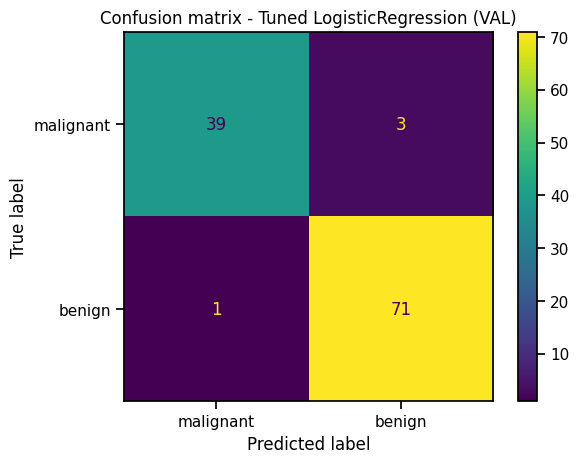


Detaljer per klass (classification_report)
              precision    recall  f1-score   support

   malignant       0.97      0.93      0.95        42
      benign       0.96      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

TN=39, FP=3, FN=1, TP=71
Tolkning
- FP: vi flaggade positivt med det var negativt
- FN: vi missade positivt (ofta allvarligt i medicinska exempel)


{'accuracy': 0.9649122807017544,
 'precision': 0.9594594594594594,
 'recall': 0.9861111111111112,
 'f1': 0.9726027397260274,
 'cm': array([[39,  3],
        [ 1, 71]])}

In [36]:
best_model = grid.best_estimator_

tuned_val = evaluate_on_validation(best_model, "Tuned LogisticRegression", X_val, y_val, target_names)
tuned_val

## Refit på train + val och sluttest


FINAL MODEL (test) - VALIDATION

Accuracy  : 0.939
Precicion : 0.910
Recall    : 1.000
F1        : 0.953


c:\Users\joaki\Desktop\ML-course\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


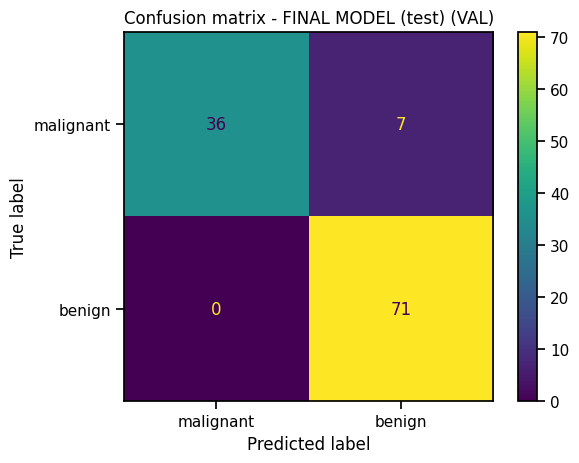


Detaljer per klass (classification_report)
              precision    recall  f1-score   support

   malignant       1.00      0.84      0.91        43
      benign       0.91      1.00      0.95        71

    accuracy                           0.94       114
   macro avg       0.96      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114

TN=36, FP=7, FN=0, TP=71
Tolkning
- FP: vi flaggade positivt med det var negativt
- FN: vi missade positivt (ofta allvarligt i medicinska exempel)


{'accuracy': 0.9385964912280702,
 'precision': 0.9102564102564102,
 'recall': 1.0,
 'f1': 0.9530201342281879,
 'cm': array([[36,  7],
        [ 0, 71]])}

In [37]:
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

best_model.fit(X_trainval, y_trainval)

final_test = evaluate_on_validation(best_model, "FINAL MODEL (test)", X_test, y_test, target_names)
final_test